In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(memory_limit='16GB')
client = Client(cluster)
client

In [2]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [3]:
# Add a unique id to each sample
from src.utils.utils import compute_signal_hash

def compute_unique_id(row):
  return str(compute_signal_hash(row))

metadata['unique_id'] = metadata.apply(compute_unique_id, axis=1)

cols = metadata.columns.tolist()
cols = [cols[-1]] + cols[:-1]
metadata = metadata[cols]
metadata


,unique_id,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,db76e9927,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,0e1116d9d,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,8ec6d3c8c,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,662b0bd39,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,ca946aadb,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,368247dd8,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,a7a60ad75,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,97f63909c,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,a5399830b,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [4]:
import dask.dataframe as dd
from src.utils import compute_signal_hash

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
          ]

def load_signals(metadata):
  rows = len(metadata)
  eeg_list = []

  for row in range(0,rows):
    sample = metadata.iloc[row]
    f_name = f'data/eeg/{sample.eeg_id}.parquet'
    eeg = pd.read_parquet(f_name)[channel_order]
    eeg_offset = int(sample.eeg_label_offset_seconds)

    eeg['unique_id'] = sample['unique_id']
    eeg = eeg.set_index('unique_id')

    eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
    eeg_list.append(eeg)

  return dd.concat(eeg_list)

ddf = load_signals(metadata)


In [5]:
# Compute 150 signals to start
df = ddf.partitions[:150].compute()
eeg_ids = list(set(df.index))
df

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
unique_id,,,,,,,,,,,,,,,,,,,
db76e9927,-14.780000,-33.049999,-8.910000,-5.60,-21.650000,1.780000,-26.129999,9.850000,-16.209999,-33.310001,-17.459999,3.220000,-5.170000,-14.370000,-13.940000,-24.629999,-4.620000,-27.780001,-17.980000
db76e9927,-8.100000,-34.610001,-26.570000,-2.77,-20.350000,0.660000,-35.130001,13.400000,-16.600000,-36.060001,-17.309999,15.120000,-3.140000,-15.580000,-15.910000,-25.969999,-1.740000,-28.480000,-20.629999
db76e9927,-3.530000,-34.709999,17.120001,15.57,-19.110001,-0.770000,-24.709999,30.219999,-8.930000,-32.369999,-23.840000,-2.820000,14.670000,-6.310000,-8.610000,-20.760000,4.840000,-18.500000,-10.460000
db76e9927,-3.370000,-29.330000,13.520000,11.71,-20.629999,-4.140000,10.330000,24.660000,-10.640000,-33.750000,-32.400002,-4.810000,14.880000,-5.840000,-11.610000,-24.910000,-2.940000,-18.680000,-13.950000
db76e9927,-3.830000,-27.459999,14.320000,-2.42,-20.000000,-3.300000,-9.990000,19.590000,-12.090000,-35.860001,-27.650000,7.830000,4.900000,-11.270000,-16.000000,-27.860001,-4.780000,-25.540001,-20.190001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
080010ed0,1.600000,16.750000,-15.420000,-22.60,-17.809999,8.510000,-0.530000,-15.680000,-23.930000,-18.870001,3.990000,-31.900000,-41.740002,-49.980000,-3.720000,-3.460000,-23.660000,-7.980000,-20.469999
080010ed0,13.560000,29.510000,-4.790000,-12.23,-11.170000,11.700000,-9.040000,-5.320000,-14.620000,-14.360000,13.030000,-30.309999,-34.029999,-40.410000,-0.530000,3.720000,-21.799999,-6.110000,-13.290000
080010ed0,36.419998,49.180000,18.080000,10.37,10.370000,39.880001,47.320000,16.480000,7.440000,7.180000,18.080000,5.850000,-13.560000,-20.740000,20.469999,25.790001,-3.190000,16.480000,11.430000


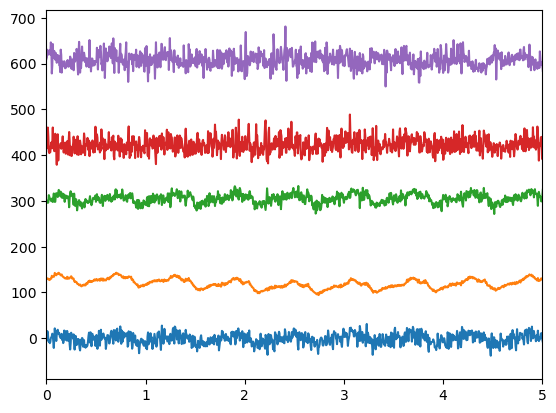

<Figure size 640x480 with 0 Axes>

In [77]:
# from src.preprocessing.preprocessing import wavelet_transform
from src.visualize import plot_signal
import numpy as np

sig = df.loc['db76e9927']

plot_signal(sig, 5, ['F3',	'Fz',	'F4',	'F8',	'T3'])


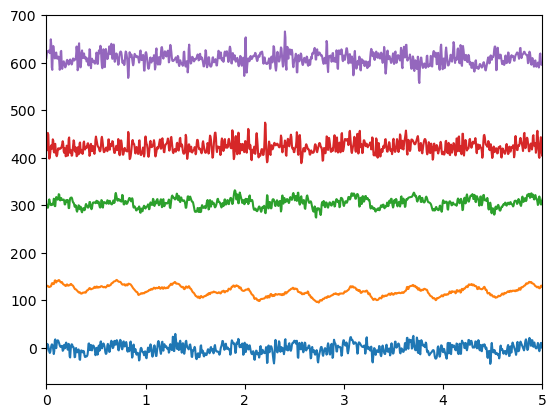

<Figure size 640x480 with 0 Axes>

In [81]:
from src.preprocessing.preprocessing import wavelet_transform

sig_denoised = wavelet_transform(sig, 2, basis='bior3.3')
plot_signal(sig_denoised, 5, ['F3',	'Fz',	'F4',	'F8',	'T3'])

Extracting top 3 channels based on max variance for all samples
- 1000 samples computation duration = approx. 15 minutes

In [63]:
from src.feature_extraction import calculate_all_samples

top_channels_df = calculate_all_samples(df, eeg_ids, len(eeg_ids))
top_channels_df

,0,1,2
36ac90aff,C3,F8,C4
8b0013ff7,Fp2,Fp1,T4
3c8fcc543,F3,Fp1,F7
4750960aa,Fp1,Fp2,F8
9e2875712,O2,T4,Fp2
...,...,...,...
3412bba45,O1,Fp1,F4
7851ae067,O2,Fz,F4
3477b30b9,Fp1,Fp2,F8
afd05328c,P4,Fp2,T4


Extracting Statistical Features from every sample with extraction function
- 1000 samples computation duration = approx. 20 minutes

In [64]:
from src.feature_extraction import extract_features_all_samples

features_df = extract_features_all_samples(df, top_channels_df)
features_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
36ac90aff,40.995753,-24.140774,214.573334,-144.503334,1702.268717,-28.811667,0.799604,4.722155,5.06698,15294877.166667,259077498174.945923
8b0013ff7,57.166023,-6.710569,254.513341,-208.893331,3271.751872,-7.516667,0.216467,3.689419,5.142412,39506690.666667,343159026681.244934
3c8fcc543,39.128506,-18.154184,99.123332,-167.376668,1561.593506,-17.018333,-0.226589,3.183058,5.088536,8668371.333333,190246732971.70462
4750960aa,181.196177,-22.897501,493.659993,-906.636658,40367.394206,16.135,-0.981233,5.754389,5.445233,22138545450.666668,4164673944975.377441
9e2875712,113.938972,-0.093651,500.560008,-406.726664,13056.590169,-2.18,0.132235,3.367897,5.117343,596817984.0,1305970260274.316162
...,...,...,...,...,...,...,...,...,...,...,...
3412bba45,36.301457,-111.845258,-3.09,-264.566676,1366.336609,-107.853338,-0.490051,3.402023,5.059295,6912627.75,1392288797302.639893
7851ae067,221.085564,-6.89718,659.906667,-746.996643,107088.067627,-1.988335,0.424078,4.156672,5.272755,101670438891.333328,10735867308581.410156
3477b30b9,130.873899,4.227969,588.649984,-555.406647,17792.215169,-0.615,0.09408,5.604089,5.23728,2485401973.333333,1781553013630.041016
afd05328c,40.667924,0.266327,98.816668,-114.269999,2817.330851,0.555,-0.258172,3.188885,4.969531,36343602.244792,289203431019.702209


Setting up Feature Data and Target Data for correct format to split data and Input to Microsoft's Light Gradient Boosting Machine (LGBM)

In [65]:
# Setup feature table
# input_df = pd.merge(features_df, metadata[['unique_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']], left_index=True, right_on='unique_id')
input_df = pd.merge(features_df, metadata[['unique_id', 'expert_consensus']], left_index=True, right_on='unique_id')
input_df = input_df.set_index('unique_id')
input_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow,expert_consensus
unique_id,,,,,,,,,,,,
36ac90aff,40.995753,-24.140774,214.573334,-144.503334,1702.268717,-28.811667,0.799604,4.722155,5.06698,15294877.166667,259077498174.945923,LPD
8b0013ff7,57.166023,-6.710569,254.513341,-208.893331,3271.751872,-7.516667,0.216467,3.689419,5.142412,39506690.666667,343159026681.244934,LPD
3c8fcc543,39.128506,-18.154184,99.123332,-167.376668,1561.593506,-17.018333,-0.226589,3.183058,5.088536,8668371.333333,190246732971.70462,GRDA
4750960aa,181.196177,-22.897501,493.659993,-906.636658,40367.394206,16.135,-0.981233,5.754389,5.445233,22138545450.666668,4164673944975.377441,LPD
9e2875712,113.938972,-0.093651,500.560008,-406.726664,13056.590169,-2.18,0.132235,3.367897,5.117343,596817984.0,1305970260274.316162,Seizure
...,...,...,...,...,...,...,...,...,...,...,...,...
3412bba45,36.301457,-111.845258,-3.09,-264.566676,1366.336609,-107.853338,-0.490051,3.402023,5.059295,6912627.75,1392288797302.639893,LRDA
7851ae067,221.085564,-6.89718,659.906667,-746.996643,107088.067627,-1.988335,0.424078,4.156672,5.272755,101670438891.333328,10735867308581.410156,GPD
3477b30b9,130.873899,4.227969,588.649984,-555.406647,17792.215169,-0.615,0.09408,5.604089,5.23728,2485401973.333333,1781553013630.041016,Seizure


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

x = input_df.iloc[:, :11].astype(float).to_numpy()
y = input_df[['expert_consensus']].to_numpy().flatten()

ordinal_encoder = LabelEncoder()
y = ordinal_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


Inputting Parameters for LGBM Model
- parameters were obtained by observing similiar implementation in same competition project using LGBM library. (see report doc --> citations/acknowledgements for more details) 
- Slight adjustments to parameters applied to fit our implementation

In [67]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

params = {
    'objective': 'multiclass',
    'num_class': 6,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'num_leaves': 121,
    'learning_rate': 0.018623105710769177,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.756777580360579,
    'max_depth': 8,
    'verbose': 0
}

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 11
[LightGBM] [Info] Start training from score -1.843053
[LightGBM] [Info] Start training from score -1.843053
[LightGBM] [Info] Start training from score -2.222542
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.696449
[LightGBM] [Info] Start training from score -1.651998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

LGBMClassifier()

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.26666666666666666

Splitting Data 80/20 and adjusting params to obtain training and testing sets

Training our LGBM model on the training data and evaluating it on the test data - Probabilities for each target label are obtained and Displayed

In [ ]:
# lgb_model.fit(X_train, y_train)
# y_pred_proba = lgb_model.predict_proba(X_test)

# # Predicted probabilities to DataFrame
# pred_df = pd.DataFrame(y_pred_proba, columns=['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
# pred_df['eeg_id'] = X_test.index
# pred_df = pred_df[['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]

# pred_df

Generating Confusion Matrix with predicted labels and true labels

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = lgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

Generating result metrics to evaluate our multiclassification model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Preprocessing Data: Applying Wavelet Transform, Notch filter, Standardization to our data
- Model was trained without preprocessing due to higher scores without

In [ ]:
## Apply the wavelet transform
import pywt
from src.preprocessing import wavelet_transform

max_levels = pywt.dwt_max_level(data_len=10000, filter_len=pywt.Wavelet('coif1').dec_len)

for sig_id in eeg_ids:
  df.loc[sig_id] = wavelet_transform(df.loc[sig_id], max_levels)

In [ ]:
## MNE setup
import mne
import numpy as np

mne_info = mne.create_info(ch_names=sig1.columns.tolist(), sfreq=200, ch_types='eeg')
mne_info.set_montage('standard_1020')
    
sig1_data = np.array(sig1.transpose())
sig1_data = np.nan_to_num(sig1_data)

raw = mne.io.RawArray(sig1_data, mne_info)
raw.apply_function(lambda x: x / 20e6, picks='eeg')

In [ ]:
# Apply filters
from src.preprocessing import notch_filter, bp_filter, standardize

l_freq = 1.0
h_freq = 70.0

df = notch_filter(df, 60)
df = bp_filter(df, 1.0, 70)
df = standardize(df)
df

In [ ]:
# File created to test the correctness of extracted values using MATLAB
# Save Fp1 channel data into a MATLAB file
# import scipy.io
# scipy.io.savemat('Fp1_data.mat', {'Fp1_data': sig1['Fp1']})